<a href="https://colab.research.google.com/github/EA-park/AIFFEL/blob/main/%5BExp_07%5DCamera_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#루브릭

1. 자기만의 카메라앱 기능 구현을 완수하였다.
 - 얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.

2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
 - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.

3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
 - 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

라이브러리

In [2]:
# path
from os.path import join
from google.colab import drive

# image
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 


Step 1. 스티커 및 사진 경로 설정

In [3]:
ROOT = '/content/gdrive'
drive.mount(ROOT)

Mounted at /content/gdrive


In [4]:
PROJ = 'MyDrive/AIFFEL/Exp-07'
WORKING_DIR = join(ROOT, PROJ)

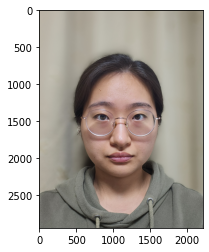

In [79]:
my_image_path = join(WORKING_DIR, 'selfie.png') # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

In [88]:
print(img_bgr.shape)

(2944, 2208, 3)


Step 2. 얼굴 검출 & 랜드마크 검출 하기

In [8]:
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(485, 1125) (1635, 2275)]]


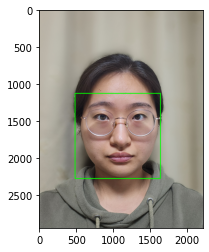

In [80]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Step 3. 스티커 적용 위치 확인하기

In [17]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 /content/gdrive/MyDrive/AIFFEL/Exp-07
!bzip2 -d /content/gdrive/MyDrive/AIFFEL/Exp-07/shape_predictor_68_face_landmarks.dat.bz2

--2022-10-10 11:43:45--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  50.5MB/s    in 1.2s    

2022-10-10 11:43:46 (50.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [81]:
model_path = join(WORKING_DIR, 'shape_predictor_68_face_landmarks.dat')
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [82]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


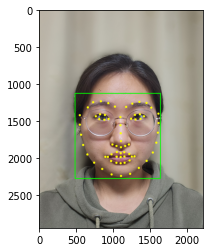

In [83]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 15, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

Step 4. 스티커 적용하기

In [84]:
# dlib_rects : 얼굴 영역을 저장하고 있는 값 → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (f"코의 위치 : {landmark[30]}") # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] # 이미지에서 코 부위의 y값
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y,w,h) : ({x}, {y}, {w}, {h})')

코의 위치 : (1103, 1770)
(x,y,w,h) : (1103, 1770, 1151, 1151)


(1151, 1151, 4)


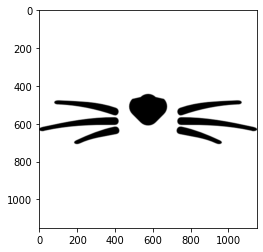

In [90]:
sticker_path = join(WORKING_DIR, 'cat_whiskers.png') # 이미지의 경로
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
height,width,c = img_sticker.shape
ratio = width/height
h = int(w/ratio)

img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

plt.imshow(img_sticker)
plt.show()

In [105]:
sticker_area = img_show[y:y+1151, 0:1151]

img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = np.where(img_sticker[:,:,0:3]==0,sticker_area,img_sticker[:,:,0:3]).astype(np.uint8)

ValueError: ignored

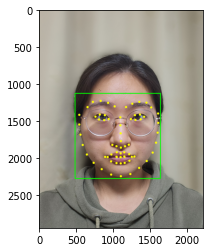

In [68]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

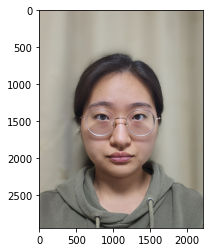

In [50]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

Step 5. 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

#회고

1. 이번 프로젝트에서 어려웠던 점

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점 
 1) 알아낸 점

 2) 모호한 점

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

4. 다짐